In [2]:
!pip install --default-timeout=100 --quiet optuna gluonts comet_ml pandas torch lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.4/677.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [3]:
from comet_ml import Experiment

import time
import json
import numpy as np
np.bool = np.bool_
import optuna
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.model.forecast import SampleForecast
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.util import to_pandas
from gluonts.dataset.split import split
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from pytorch_lightning.loggers import CometLogger
from pathlib import Path
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [7]:
prediction_length = 24
hyperparameters = {
    # Num cells and hidden size are the same thing.
    'hidden_size': 64,
    'num_cells': 64,
    'num_layers':5,
    'cell_type': 'lstm',
    'context_length': 434,
    'training_end_year': 2024,
    'epochs': 32,
    'num_batches_per_epoch': 75,
    'learning_rate': 0.005,
    #'batch_size':
}

## Using MX DeepAR

In [ ]:
!pip install mxnet
import mxnet as mx
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    freq="1H",
    num_cells=hyperparameters['num_cells'],
    num_layers=hyperparameters['num_layers'],
    prediction_length=prediction_length,
    context_length=hyperparameters['context_length'],
    cell_type=hyperparameters['cell_type'],
    use_feat_dynamic_real=True,
    # use_feat_static_cat=True,
    cardinality=[2],
    trainer=Trainer(
        epochs=hyperparameters['epochs'],
        num_batches_per_epoch=hyperparameters['num_batches_per_epoch'],
        learning_rate=hyperparameters['learning_rate'],

      )
)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Using PyTorch DeepAR

In [5]:
estimator = DeepAREstimator(
    freq="1H",
    num_layers=hyperparameters['num_layers'],
    hidden_size=hyperparameters['hidden_size'],
    prediction_length=prediction_length,
    context_length=hyperparameters['context_length'],
    #batch_size=hyperparameters['batch_size'],
    num_feat_dynamic_real=2,
    # use_feat_dynamic_cat=True,
    # cardinality=[2],
    num_batches_per_epoch=hyperparameters['num_batches_per_epoch'],
    lr=hyperparameters['learning_rate'],
    trainer_kwargs= {
        'accelerator': 'gpu',
        'devices': 1,
        'max_epochs': hyperparameters['epochs'],
    }
)

## Prepare Data

In [5]:
def prepare_dataset(df: pd.DataFrame):
    return ListDataset (
        [
            {
                FieldName.START: df.index[0],
                FieldName.TARGET: df['Price'].values,
                FieldName.FEAT_DYNAMIC_CAT: [
                    # df['Day'].values,
                    # df['Month'].values,
                    # df['Year'].values,
                    # df['Hour'].values,
                    # df['Weekday'].values,
                    df['Holiday'].values,
                    # df['Mod168'].values,
                ],
                FieldName.FEAT_DYNAMIC_REAL: [
                    df['BalancingMarketPrice'].values,
                    df['ForecastedDemandSupply'].values,
                ],
            }
        ],
        freq='1H'
    )

In [8]:
dataset = pd.read_csv('drive/MyDrive/colab/data.csv', index_col=0, parse_dates=True)

df_train = dataset[dataset.index.year < hyperparameters['training_end_year']]
df_test = dataset
#df_test.loc[df_test.index[-24:], 'Price'] = np.nan
train_data = prepare_dataset(df_train)
test_data = prepare_dataset(df_test)

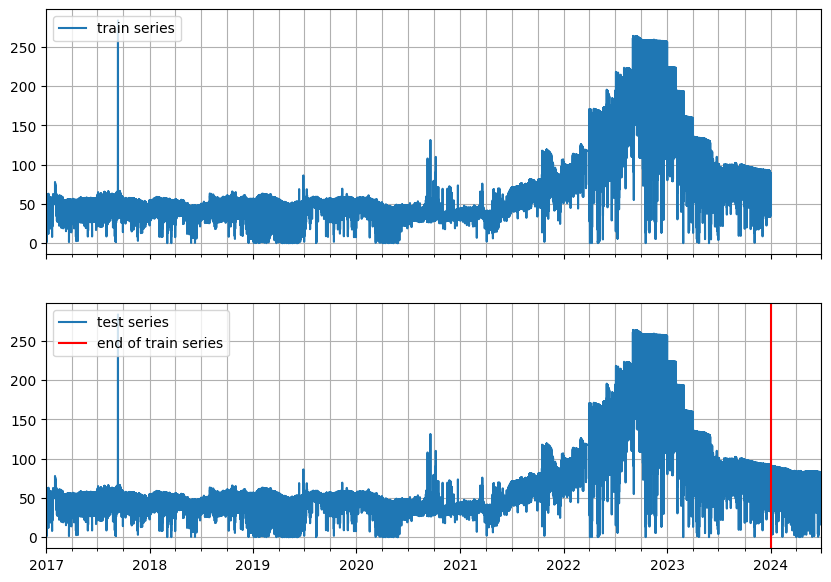

In [9]:
train_entry = next(iter(train_data))
test_entry = next(iter(test_data))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()


## Transformations??

In [ ]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                instance_sampler=ExpectedNumInstanceSampler(
                    num_instances=1,
                    min_future=prediction_length,
                ),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

In [ ]:
transformation = create_transformation(
    freq='1H',
    context_length=720,
    prediction_length=prediction_length
)
train_tf = transformation(iter(train_data), is_train=True)
train_tf_entry = next(iter(train_tf))
train_tf_df = to_pandas(train_tf_entry)

## Hyperparameter Optimization

In [12]:
def dataentry_to_dataframe(entry):
    df = pd.DataFrame(
        entry['target'],
        columns=['Price'],
        index=pd.period_range(
            start=entry['start'], periods=len(entry['target']), freq=entry['start'].freq
        ),
    )

    return df

class DeepARTuningObjective:
    def __init__(self, dataset, prediction_length, freq, metric_type='mean_wQuantileLoss'):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type

        self.train, test_template = split(dataset, offset=-self.prediction_length)
        validation = test_template.generate_instances(
            prediction_length=prediction_length
        )
        self.validation_input = [entry[0] for entry in validation]
        self.validation_label = [
            dataentry_to_dataframe(entry[1]) for entry in validation
        ]

    def get_params(self, trial):
        return {
            'num_layers': trial.suggest_int('num_layers', 2, 5),
            'hidden_size': trial.suggest_int('hidden_size', 64, 128),
            'context_length': trial.suggest_int('context_length', 24, 720),
            'epochs': trial.suggest_int('epochs', 8, 50),
            'num_batches_per_epoch': trial.suggest_int('num_batches_per_epoch', 30, 300),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
        }

    def __call__(self, trial):
        comet_logger = CometLogger(api_key='O35hn5O1ER5tego7HI55dPH5a', project_name='deepar-torch')
        params = self.get_params(trial)
        estimator = DeepAREstimator(
            freq=self.freq,
            num_layers=params["num_layers"],
            hidden_size=params["hidden_size"],
            prediction_length=self.prediction_length,
            context_length=params["context_length"],
            num_batches_per_epoch=params["num_batches_per_epoch"],
            lr=params["learning_rate"],
            trainer_kwargs={
                'accelerator': 'gpu',
                'devices': 1,
                'max_epochs': params["epochs"],
                'enable_progress_bar': False,
                'enable_model_summary': False,
                'logger':comet_logger,
            }
        )

        predictor = estimator.train(self.train, cache_data=True)
        forecast_it = predictor.predict(self.validation_input)

        forecasts = list(forecast_it)

        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(
            self.validation_label, forecasts, num_series=len(self.validation_input)
        )
        comet_logger.log_metrics(agg_metrics)
        comet_logger.log_hyperparams(params)
        comet_logger.experiment.end()
        return agg_metrics[self.metric_type]


In [ ]:
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(
    DeepARTuningObjective(
        train_data, prediction_length, '1h'
    ),
    n_trials=50,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print(time.time() - start_time)

# Predictions

In [13]:
windows = 60
train, test_template = split(test_data, offset=-prediction_length * windows)
test = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=windows
)
test_input = [entry[0] for entry in test]
test_label = [
    dataentry_to_dataframe(entry[1]) for entry in test
]

Train the model

In [ ]:
predictor = estimator.train(training_data=train, cache_data=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                         | Out sizes   
--------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 163 K  | train | [[1, 1], [

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 75: 'train_loss' reached 4.13751 (best 4.13751), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=0-step=75.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 75: 'train_loss' reached 4.13751 (best 4.13751), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=0-step=75.ckpt' as top 1
INFO: Epoch 1, global step 150: 'train_loss' reached 3.79901 (best 3.79901), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=1-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 150: 'train_loss' reached 3.79901 (best 3.79901), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=1-step=150.ckpt' as top 1
INFO: Epoch 2, global step 225: 'train_loss' reached 3.53714 (best 3.53714), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=2-step=225.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 225: '

Save the model

In [ ]:
# Save the model
predictor.serialize(Path("drive/MyDrive/colab/models/deepar-gluon"))

Load the model

In [4]:
# Load the model
predictor = Predictor.deserialize(Path("drive/MyDrive/colab/models/deepar-gluon"))

In [14]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_input,
    predictor=predictor,
    num_samples=720
)

In [15]:
forecasts = list(forecast_it)
tss = list(ts_it)

forecast_entry = forecasts[-1]
ts_entry = tss[-1]

In [85]:
forecasts[1]

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[82.939   , 84.216385, 77.302284, ..., 75.44311 , 72.72446 ,
        90.217094],
       [78.50592 , 82.699425, 69.686584, ..., 73.21367 , 73.53698 ,
        68.34781 ],
       [76.50844 , 97.21922 , 77.31513 , ..., 81.63458 , 66.3472  ,
        70.58318 ],
       ...,
       [74.14075 , 83.10395 , 82.96296 , ..., 72.12588 , 59.916286,
        49.727364],
       [75.407585, 79.92634 , 79.149185, ..., 92.23934 , 85.40288 ,
        59.49033 ],
       [79.53504 , 69.56195 , 56.406883, ..., 44.905724, 34.311405,
        44.0399  ]], dtype=float32), start_date=Period('2024-04-28 00:00', 'H'))

In [22]:
total_forecast = SampleForecast(
    info=None,
    item_id=None,
    samples=np.hstack([forecast.samples for forecast in forecasts[-10:]]),
    start_date=forecasts[-10].start_date
)

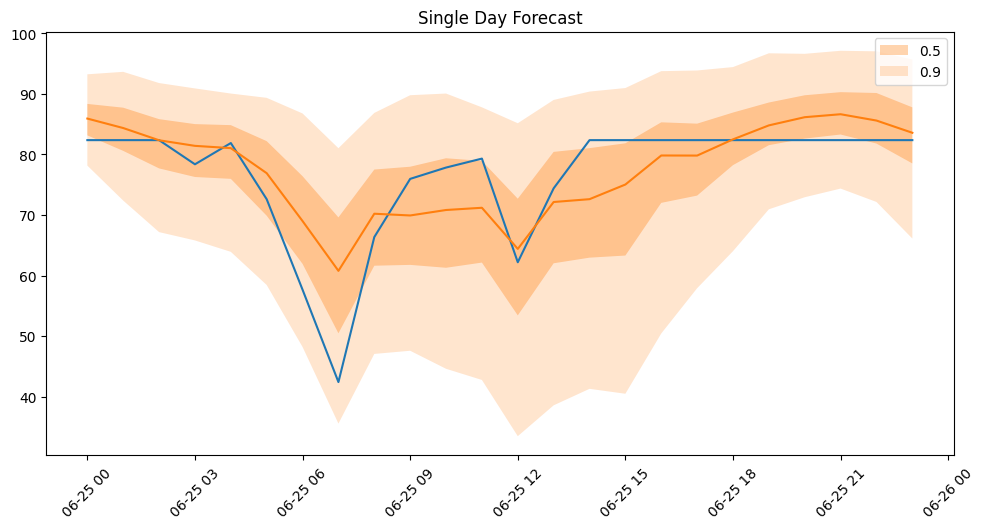

In [53]:
plt.figure(figsize=(10, 5))
plt.title(f'Single Day Forecast')
plt.plot(ts_entry[-24:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()

In [18]:
index = pd.date_range(start=total_forecast.start_date.to_timestamp(), periods=len(total_forecast.samples[0]), freq='1H')

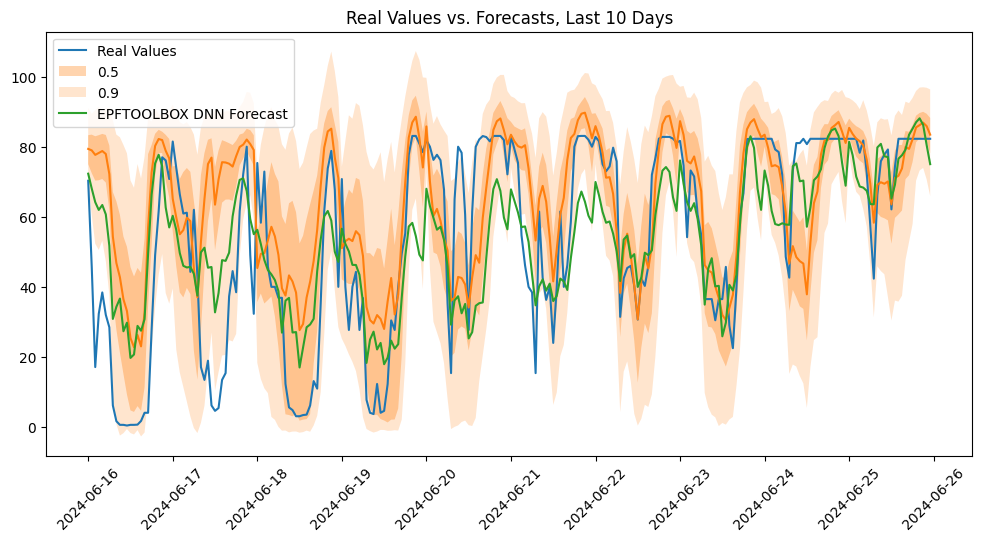

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(tss[-1][-240:].to_timestamp(), label='Real Values')
total_forecast.plot(show_label=True)
plt.plot(epftoolbox_forecast, label='EPFTOOLBOX DNN Forecast')
plt.title('Real Values vs. Forecasts, Last 10 Days')
# plt.plot(index, np.mean(total_forecast.samples, axis=0, keepdims=True)[0])
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()

In [32]:
epftoolbox_forecast = np.array([72.38990784, 68.1591568 , 64.2547226 , 62.03053284, 63.44394302,
       60.75633621, 51.77719879, 30.89319992, 34.35956955, 36.69999695,
       27.36541748, 29.81179047, 19.74354553, 20.72451401, 28.90070343,
       27.52229309, 30.81548691, 49.32971573, 66.33644104, 75.34506226,
       77.79327393, 74.57423401, 62.74057007, 57.02738571, 60.35231781,
       56.33761978, 49.70407486, 46.0565567 , 45.58931351, 45.76744843,
       43.75770187, 37.55085373, 49.91209793, 51.24066544, 45.52288055,
       45.72430038, 32.76491928, 38.28264618, 47.6887207 , 47.472332  ,
       49.82640457, 60.20545959, 66.14318085, 70.62188721, 71.05970764,
       67.43988037, 59.40914536, 55.1031189 , 56.34375763, 52.30641937,
       47.72186279, 44.87852859, 43.61629105, 41.98094559, 38.80735397,
       26.96465683, 36.10216141, 36.90150452, 27.00751495, 27.1293869 ,
       17.01470566, 22.69984055, 28.51022339, 29.30601501, 30.91962051,
       44.54231262, 53.59435654, 60.23901367, 61.74096298, 59.01862335,
       50.09396362, 47.19037247, 56.6578064 , 52.32998276, 50.16342163,
       46.33145523, 46.30311584, 43.50688171, 35.60535049, 18.31549072,
       24.98182678, 27.24848175, 22.1601944 , 24.03370667, 17.94577408,
       19.84567642, 24.68384933, 22.3866272 , 23.68161774, 36.99749374,
       48.72600174, 57.30194092, 58.33973312, 54.55220795, 49.24901962,
       47.60295486, 68.0798645 , 63.13611603, 59.78819275, 56.38580322,
       57.222229  , 53.46286774, 45.91246033, 29.23125839, 36.1888237 ,
       37.37346268, 32.49708557, 35.17799759, 25.31692886, 27.09209442,
       34.64305115, 35.38493729, 35.59455109, 48.3781662 , 59.54064941,
       67.99452972, 70.82713318, 67.48851013, 59.83115387, 56.48698425,
       67.91466522, 64.55633545, 61.29997253, 57.10886765, 57.3290596 ,
       52.86758041, 43.47929382, 34.77442551, 40.1711731 , 42.17734146,
       38.97029877, 40.97806549, 35.99464035, 37.45394516, 42.41192627,
       41.62341309, 39.16505051, 48.27944565, 55.66152573, 64.01935577,
       67.28362274, 64.38172913, 60.39361572, 58.39349365, 70.02949524,
       66.1812973 , 61.50126266, 58.37214279, 58.73592377, 55.23937225,
       50.250103  , 41.71523285, 53.57649612, 54.70936966, 48.34904099,
       49.39699173, 40.02775574, 42.68096924, 49.81064224, 49.10997772,
       50.47597122, 60.6390152 , 67.20890808, 73.26052856, 74.2850647 ,
       72.88043976, 65.62575531, 61.76545715, 76.17097473, 69.56759644,
       64.23838806, 61.75965881, 63.9673996 , 59.38929749, 51.95561218,
       34.97821045, 45.25675201, 48.24063873, 40.19041824, 40.34051895,
       25.92337418, 29.80229187, 40.62792969, 39.00842285, 43.4864006 ,
       57.75478745, 69.29498291, 80.009552  , 83.08117676, 79.75732422,
       68.15132141, 62.04979706, 73.29037476, 68.99905396, 61.76142883,
       57.992939  , 57.68384933, 58.23108673, 57.86330414, 57.78414917,
       74.53176117, 75.31268311, 70.21800995, 70.42805481, 57.2317009 ,
       62.73304749, 70.52463531, 71.59337616, 73.67269897, 79.71318817,
       83.04441071, 84.75688934, 85.29764557, 83.12374115, 75.43825531,
       68.95495605, 81.50226593, 77.645401  , 71.5647049 , 68.72389221,
       68.41351318, 67.48796844, 63.71115875, 63.62874603, 79.88439178,
       80.91503143, 77.37652588, 77.12345123, 65.27514648, 69.24166107,
       76.67178345, 77.67100525, 79.27272797, 83.50588989, 85.25098419,
       87.10222626, 88.2093277 , 86.35138702, 80.55958557, 75.10909271])

In [33]:
idx = pd.date_range(start=total_forecast.start_date.to_timestamp(), periods=len(total_forecast.samples[0]), freq='1H')
epftoolbox_forecast = pd.DataFrame(data=epftoolbox_forecast, index=idx)

In [36]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 60it [00:00, 1475.74it/s]


{
    "MSE": 213.6427092658149,
    "abs_error": 14435.45352935791,
    "abs_target_sum": 91594.12896728516,
    "abs_target_mean": 63.607034005059134,
    "seasonal_error": 10.376259745252119,
    "MASE": 0.966192361974617,
    "MAPE": 0.7669417152388228,
    "sMAPE": 0.2324261834224065,
    "MSIS": 6.748739026491679,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 7758.780231505633,
    "Coverage[0.1]": 0.10277777777777779,
    "QuantileLoss[0.5]": 14435.453626155853,
    "Coverage[0.5]": 0.6284722222222222,
    "QuantileLoss[0.9]": 5928.4904800415015,
    "Coverage[0.9]": 0.976388888888889,
    "RMSE": 14.61652179096706,
    "NRMSE": 0.2297941103464202,
    "ND": 0.15760238884430952,
    "wQuantileLoss[0.1]": 0.08470827026781215,
    "wQuantileLoss[0.5]": 0.15760238990112338,
    "wQuantileLoss[0.9]": 0.06472566033308741,
    "mean_absolute_QuantileLoss": 9374.241445900996,
    "mean_wQuantileLoss": 0.10234544016734098,
    "MAE_Coverage": 0.4763888888888889,
    "OWA"